# Imports

In [3]:
import pandas as pd
import numpy as np
import src.dataclass as dataclass
import src.correlation_coefficient as correlation_coefficient
import src.plot_ts as plot_ts
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as ltb

from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

2023-06-25 15:03:57.600556: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 15:03:57.690780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-25 15:03:57.691432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 15:03:58.330818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
lead_times = [0, 1, 3, 6]
climate_models = ["CESM", "FOCI"]

model_name = "LightGBM"
results = dict()
show_plots = False
feats = [
    "AMO",
    "ENSO_12",
    "ENSO_34",
    "ENSO_4",
    "NAO_PC",
    "PDO_PC",
    "PREC_SAHEL",
    "SAM_ZM",
    "SAT_N_OCEAN",
    "SAT_S_ALL",
    "SAT_S_OCEAN",
    "SOI",
    "SSS_ENA",
    "SST_MED",
    "SST_TNA",
]

for lead_time in lead_times:
    results[f"Lead_time: {lead_time}"] = dict()

for climate in climate_models:
    for lead_time in lead_times:
        seq_length = 1
        data = dataclass.Data(
            lead_time=lead_time,
            seq_length=seq_length,
            # split=[0.8, 0.1, 0.1],
            feature_list=feats
        )

        if climate == "CESM":
            x_train = np.array(data.train_input_CESM)
            y_train = np.array(data.train_target_CESM)

            # x_val = np.array(data.validation_input_CESM)
            # y_val = np.array(data.validation_target_CESM)

            x_test = np.array(data.test_input_CESM)
            y_test = np.array(data.test_target_CESM)
        elif climate == "FOCI":
            x_train = np.array(data.train_input_FOCI)
            y_train = np.array(data.train_target_FOCI)

            # x_val = np.array(data.validation_input_FOCI)
            # y_val = np.array(data.validation_target_FOCI)

            x_test = np.array(data.test_input_FOCI)
            y_test = np.array(data.test_target_FOCI)

        if seq_length != None:
            x_train = x_train.reshape(
                (x_train.shape[0], x_train.shape[1] * x_train.shape[2])
            )
            x_test = x_test.reshape(
                (x_test.shape[0], x_test.shape[1] * x_test.shape[2])
            )

        ltb_model = ltb.LGBMRegressor()
        ltb_model.fit(x_train, y_train)

        predictions = ltb_model.predict(x_test)
        mse = mean_squared_error(predictions, y_test)
        correlation = np.corrcoef(predictions, y_test)[1, 0]
        

        if show_plots:

            print(f"The MSE is: {mse}, the correlation coefficient is: {correlation}")

            plot_ts.plot_ts(
                true=data.test_target_CESM,
                predicted=predictions,
                ts_start=10794,
                ts_end=10994,
                title=f"XGBoost {climate}, lead time = {lead_time}, window_size = {seq_length}",
            )
        results[f"Lead_time: {lead_time}"]["Modelname"] = model_name
        results[f"Lead_time: {lead_time}"][f"{climate}_MSE"] = mse
        results[f"Lead_time: {lead_time}"][f"{climate}_Correlation"] = correlation
        # results[f"Lead_time: {lead_time}"][f"Leadtime"] = lead_time

df = pd.DataFrame.from_dict(results, orient="index")
df

,Modelname,CESM_MSE,CESM_Correlation,FOCI_MSE,FOCI_Correlation
Lead_time: 0,LightGBM,0.959849,0.370472,0.733980,0.305326
Lead_time: 1,LightGBM,0.909289,0.424804,0.773254,0.255781
Lead_time: 3,LightGBM,0.928713,0.403476,0.791946,0.184156
Lead_time: 6,LightGBM,0.997192,0.318318,0.813494,0.130476


In [4]:
from sklearn.feature_selection import SelectFromModel

climate = "FOCI"
lead_time = 1
seq_length = 1
data = dataclass.Data(
    lead_time=lead_time,
    seq_length=seq_length,
    split=[0.8, 0.1, 0.1],
    feature_list=[
        "ENSO_12",
        "ENSO_34",
        "ENSO_4",
        "NAO_PC",
        "NAO_ST",
        "NP",
        "PREC_SAHEL",
        "SAM_ZM",
        "SAT_N_LAND",
        "SAT_N_OCEAN",
        "SOI",
        "SSS_ENA",
        "SST_MED",
        "SST_TNA",
    ],
)

if climate == "CESM":
    x_train = np.array(data.train_input_CESM)
    y_train = np.array(data.train_target_CESM)

    x_val = np.array(data.validation_input_CESM)
    y_val = np.array(data.validation_target_CESM)

    x_test = np.array(data.test_input_CESM)
    y_test = np.array(data.test_target_CESM)
elif climate == "FOCI":
    x_train = np.array(data.train_input_FOCI)
    y_train = np.array(data.train_target_FOCI)

    x_val = np.array(data.validation_input_FOCI)
    y_val = np.array(data.validation_target_FOCI)

    x_test = np.array(data.test_input_FOCI)
    y_test = np.array(data.test_target_FOCI)

if seq_length != None:
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

model = ltb.LGBMRegressor()
model.fit(x_train, y_train)
# trans = SelectFromModel(model, threshold="median")
# x_train_transformed = trans.fit_transform(x_train, y_train)
# x_test_transformed = trans.transform(x_test)
# new_model = ltb.LGBMRegressor()
# new_model.fit(x_train_transformed, y_train)


predictions = model.predict(x_test)
mse = mean_squared_error(predictions, y_test)
correlation = np.corrcoef(predictions, y_test)[1, 0]
print(f"The MSE is: {mse}, the correlation coefficient is: {correlation}")

The MSE is: 0.7455604126432142, the correlation coefficient is: 0.2971950112587327


In [4]:
from sklearn.feature_selection import SequentialFeatureSelector
from time import time

results = dict()

for climate in ["CESM", "FOCI"]:
    results[f"Climate_index: {climate}"] = dict()
    for num_features in [15, 20, 25]:
        lead_time = 1
        seq_length = 1
        data = dataclass.Data(
            lead_time=lead_time,
            seq_length=seq_length,
            # split=[0.8, 0.1, 0.1],
        )

        feature_names = data.possible_features
        feature_names = np.array(feature_names)

        if climate == "CESM":
            x_train = np.array(data.train_input_CESM)
            y_train = np.array(data.train_target_CESM)

            # x_val = np.array(data.validation_input_CESM)
            # y_val = np.array(data.validation_target_CESM)

            x_test = np.array(data.test_input_CESM)
            y_test = np.array(data.test_target_CESM)
        elif climate == "FOCI":
            x_train = np.array(data.train_input_FOCI)
            y_train = np.array(data.train_target_FOCI)

            # x_val = np.array(data.validation_input_FOCI)
            # y_val = np.array(data.validation_target_FOCI)

            x_test = np.array(data.test_input_FOCI)
            y_test = np.array(data.test_target_FOCI)

        if seq_length != None:
            x_train = x_train.reshape(
                (x_train.shape[0], x_train.shape[1] * x_train.shape[2])
            )
            x_test = x_test.reshape(
                (x_test.shape[0], x_test.shape[1] * x_test.shape[2])
            )

        model = ltb.LGBMRegressor()

        # tic_fwd = time()
        # sfs_forward = SequentialFeatureSelector(
        #     model, n_features_to_select=num_features, direction="forward"
        # ).fit(x_train, y_train)
        # toc_fwd = time()

        tic_bwd = time()
        sfs_backward = SequentialFeatureSelector(
            model, n_features_to_select=num_features, direction="backward"
        ).fit(x_train, y_train)
        toc_bwd = time()

        # print(
        #     "Features selected by forward sequential selection: "
        #     f"{feature_names[sfs_forward.get_support()]}"
        # )
        # print(f"Done in {toc_fwd - tic_fwd:.3f}s")
        print(
            "Features selected by backward sequential selection: "
            f"{feature_names[sfs_backward.get_support()]}"
        )
        print(f"Done in {toc_bwd - tic_bwd:.3f}s")

        feature_list = [
            val
            for val in feature_names[sfs_backward.get_support()]
            if not val.startswith("month")
        ]

        data = dataclass.Data(
            lead_time=lead_time,
            seq_length=seq_length,
            # split=[0.8, 0.1, 0.1],
            feature_list=feature_list,
        )

        if climate == "CESM":
            x_train = np.array(data.train_input_CESM)
            y_train = np.array(data.train_target_CESM)

            # x_val = np.array(data.validation_input_CESM)
            # y_val = np.array(data.validation_target_CESM)

            x_test = np.array(data.test_input_CESM)
            y_test = np.array(data.test_target_CESM)
        elif climate == "FOCI":
            x_train = np.array(data.train_input_FOCI)
            y_train = np.array(data.train_target_FOCI)

            # x_val = np.array(data.validation_input_FOCI)
            # y_val = np.array(data.validation_target_FOCI)

            x_test = np.array(data.test_input_FOCI)
            y_test = np.array(data.test_target_FOCI)

        if seq_length != None:
            x_train = x_train.reshape(
                (x_train.shape[0], x_train.shape[1] * x_train.shape[2])
            )
            x_test = x_test.reshape(
                (x_test.shape[0], x_test.shape[1] * x_test.shape[2])
            )

        model = ltb.LGBMRegressor()
        model.fit(x_train, y_train)

        predictions = model.predict(x_test)
        mse = mean_squared_error(predictions, y_test)
        correlation = np.corrcoef(predictions, y_test)[1, 0]
        print(
            f"The MSE with {num_features} is: {mse}, the correlation coefficient is: {correlation}"
        )
        results[f"Climate_index: {climate}"][f"MSE_{num_features}"] = mse
        results[f"Climate_index: {climate}"][f"Correlation_{num_features}"] = correlation

df = pd.DataFrame.from_dict(results, orient="index")
df


Features selected by backward sequential selection: ['AMO' 'ENSO_12' 'ENSO_4' 'NAO_PC' 'PREC_SAHEL' 'SAM_ZM' 'SAT_S_OCEAN'
 'SOI' 'SST_MED' 'SST_TNA' 'month_5' 'month_6' 'month_7' 'month_8'
 'month_9']
Done in 527.279s
The MSE with 15 is: 0.9438138497552184, the correlation coefficient is: 0.389083500328895
Features selected by backward sequential selection: ['AMO' 'ENSO_12' 'ENSO_34' 'ENSO_4' 'NAO_PC' 'PDO_PC' 'PREC_SAHEL'
 'SAM_ZM' 'SAT_N_OCEAN' 'SAT_S_ALL' 'SAT_S_OCEAN' 'SOI' 'SSS_ENA'
 'SST_MED' 'SST_TNA' 'month_5' 'month_6' 'month_7' 'month_8' 'month_9']
Done in 336.133s
The MSE with 20 is: 0.909289470914029, the correlation coefficient is: 0.42480385966263046
Features selected by backward sequential selection: ['AMO' 'ENSO_12' 'ENSO_34' 'ENSO_4' 'NAO_PC' 'PDO_PC' 'PREC_SAHEL'
 'SAM_PC' 'SAM_ZM' 'SAT_N_OCEAN' 'SAT_S_ALL' 'SAT_S_LAND' 'SAT_S_OCEAN'
 'SOI' 'SSS_ENA' 'SST_HMDR' 'SST_MED' 'SST_TNA' 'SST_TSA' 'month_3'
 'month_5' 'month_6' 'month_7' 'month_8' 'month_9']
Done in 266.011

,MSE_15,Correlation_15,MSE_20,Correlation_20,MSE_25,Correlation_25
Climate_index: CESM,0.943814,0.389084,0.909289,0.424804,0.913363,0.420489
Climate_index: FOCI,0.769093,0.255879,0.765694,0.265179,0.752309,0.284172


In [5]:
from sklearn.feature_selection import SelectFromModel

lead_time = 1
seq_length = 1
data = dataclass.Data(
    lead_time=lead_time,
    seq_length=seq_length,
)
for climate in ['CESM', 'FOCI']:
    if climate == "CESM":
        x_train = np.array(data.train_input_CESM)
        y_train = np.array(data.train_target_CESM)

        x_test = np.array(data.test_input_CESM)
        y_test = np.array(data.test_target_CESM)
    elif climate == "FOCI":
        x_train = np.array(data.train_input_FOCI)
        y_train = np.array(data.train_target_FOCI)

        x_test = np.array(data.test_input_FOCI)
        y_test = np.array(data.test_target_FOCI)

    if seq_length != None:
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

    model = ltb.LGBMRegressor()
    model.fit(x_train, y_train)

    predictions = model.predict(x_test)
    mse = mean_squared_error(predictions, y_test)
    correlation = np.corrcoef(predictions, y_test)[1, 0]
    print(f"The MSE for {climate} is: {mse}, the correlation coefficient is: {correlation}")

The MSE for CESMis: 0.9305797556487247, the correlation coefficient is: 0.40234979568297546
The MSE for FOCIis: 0.7543741519133629, the correlation coefficient is: 0.28984110878300196


In [5]:
from sklearn.feature_selection import SequentialFeatureSelector
from time import time

for num_features in [10, 15, 20, 25]:

    climate = "FOCI"
    lead_time = 1
    seq_length = 1
    data = dataclass.Data(
        lead_time=lead_time,
        seq_length=seq_length,
        # split=[0.8, 0.1, 0.1],
    )

    feature_names = data.possible_features
    feature_names = np.array(feature_names)

    if climate == "CESM":
        x_train = np.array(data.train_input_CESM)
        y_train = np.array(data.train_target_CESM)

        # x_val = np.array(data.validation_input_CESM)
        # y_val = np.array(data.validation_target_CESM)

        x_test = np.array(data.test_input_CESM)
        y_test = np.array(data.test_target_CESM)
    elif climate == "FOCI":
        x_train = np.array(data.train_input_FOCI)
        y_train = np.array(data.train_target_FOCI)

        # x_val = np.array(data.validation_input_FOCI)
        # y_val = np.array(data.validation_target_FOCI)

        x_test = np.array(data.test_input_FOCI)
        y_test = np.array(data.test_target_FOCI)

    if seq_length != None:
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))


    model = ltb.LGBMRegressor()

    # tic_fwd = time()
    # sfs_forward = SequentialFeatureSelector(
    #     model, n_features_to_select=num_features, direction="forward"
    # ).fit(x_train, y_train)
    # toc_fwd = time()

    tic_bwd = time()
    sfs_backward = SequentialFeatureSelector(
        model, n_features_to_select=num_features, direction="backward"
    ).fit(x_train, y_train)
    toc_bwd = time()

    # print(
    #     "Features selected by forward sequential selection: "
    #     f"{feature_names[sfs_forward.get_support()]}"
    # )
    # print(f"Done in {toc_fwd - tic_fwd:.3f}s")
    print(
        "Features selected by backward sequential selection: "
        f"{feature_names[sfs_backward.get_support()]}"
    )
    print(f"Done in {toc_bwd - tic_bwd:.3f}s")


    feature_list = [val for val in feature_names[sfs_backward.get_support()] if not val.startswith('month')]

    
    data = dataclass.Data(
        lead_time=lead_time,
        seq_length=seq_length,
        # split=[0.8, 0.1, 0.1],
        feature_list=feature_list
    )

    if climate == "CESM":
        x_train = np.array(data.train_input_CESM)
        y_train = np.array(data.train_target_CESM)

        # x_val = np.array(data.validation_input_CESM)
        # y_val = np.array(data.validation_target_CESM)

        x_test = np.array(data.test_input_CESM)
        y_test = np.array(data.test_target_CESM)
    elif climate == "FOCI":
        x_train = np.array(data.train_input_FOCI)
        y_train = np.array(data.train_target_FOCI)

        # x_val = np.array(data.validation_input_FOCI)
        # y_val = np.array(data.validation_target_FOCI)

        x_test = np.array(data.test_input_FOCI)
        y_test = np.array(data.test_target_FOCI)

    if seq_length != None:
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

    model = ltb.LGBMRegressor()
    model.fit(x_train, y_train)

    predictions = model.predict(x_test)
    mse = mean_squared_error(predictions, y_test)
    correlation = np.corrcoef(predictions, y_test)[1, 0]
    print(f"The MSE with {num_features} is: {mse}, the correlation coefficient is: {correlation}")

Features selected by backward sequential selection: ['ENSO_4' 'PREC_SAHEL' 'SAT_N_ALL' 'SST_MED' 'SST_TNA' 'SST_TSA' 'month_4'
 'month_5' 'month_6' 'month_7']
Done in 490.103s
The MSE with 10 is: 0.7775068261171566, the correlation coefficient is: 0.24417781676154623
Features selected by backward sequential selection: ['ENSO_3' 'ENSO_4' 'NAO_ST' 'PREC_SAHEL' 'SAT_N_ALL' 'SOI' 'SST_ESIO'
 'SST_MED' 'SST_TNA' 'SST_TSA' 'month_4' 'month_5' 'month_6' 'month_7'
 'month_8']
Done in 351.694s
The MSE with 15 is: 0.7690926376773098, the correlation coefficient is: 0.255879481391231
Features selected by backward sequential selection: ['ENSO_3' 'ENSO_4' 'NAO_ST' 'PREC_SAHEL' 'SAM_ZM' 'SAT_N_ALL'
 'SAT_N_OCEAN' 'SOI' 'SSS_ENA' 'SST_ESIO' 'SST_HMDR' 'SST_MED' 'SST_TNA'
 'SST_TSA' 'month_4' 'month_5' 'month_6' 'month_7' 'month_8' 'month_9']
Done in 305.370s
The MSE with 20 is: 0.7656944205046489, the correlation coefficient is: 0.26517935883308025
Features selected by backward sequential selection: 

In [17]:
predictions = model.predict(x_test)
mse = mean_squared_error(predictions, y_test)
correlation = np.corrcoef(predictions, y_test)[1, 0]
print(f"The MSE is: {mse}, the correlation coefficient is: {correlation}")

The MSE is: 0.9494077752378807, the correlation coefficient is: 0.3998569594355226


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (168,).

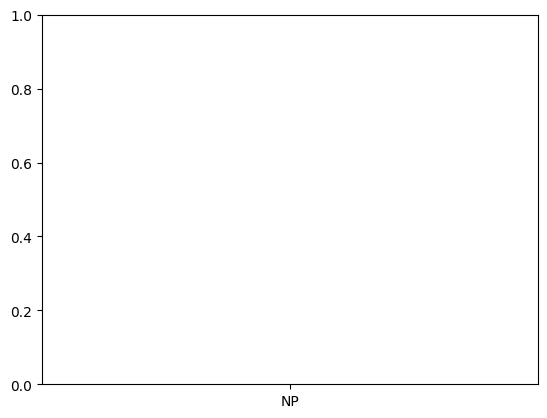

In [21]:
plt.bar(data.possible_features[:-12], ltb_model.feature_importances_[:-12])
plt.xticks(rotation=90)

# Building Tables

In [4]:
df.to_csv(f"Results_{model_name}.csv", sep=';')

In [31]:
df_GRU = pd.read_csv("Results_GRU.csv", sep=';', index_col=0)
df_XGB = pd.read_csv("Results_XGBoost.csv", sep=';', index_col=0)
df_LSTM = pd.read_csv("Results_LSTM.csv", sep=';', index_col=0)
df_CNN_LSTM = pd.read_csv("Results_CNN+LSTM.csv", sep=';', index_col=0)
df_total = pd.concat([df, df_GRU, df_XGB, df_LSTM, df_CNN_LSTM])
df_total['lead time'] = [0,0,0,0,0,1,1,1,1,1,3,3,3,3,3,6,6,6,6,6]
df_total.set_index("lead time", inplace=True)
df_total.sort_index(axis=0, inplace=True)
df_total

,Modelname,CESM_MSE,CESM_Correlation,FOCI_MSE,FOCI_Correlation
Lead_time: 0,LightGBM,0.795217,0.541215,0.591066,0.505590
Lead_time: 0,CNN+LSTM,0.772522,0.555355,0.554634,0.551180
Lead_time: 0,GRU,0.690352,0.623561,0.519549,0.585833
Lead_time: 0,LSTM,0.700556,0.612967,0.526495,0.580200
Lead_time: 0,XGBoost,0.818344,0.518608,0.690793,0.405406
Lead_time: 1,CNN+LSTM,0.943968,0.394598,0.718872,0.304757
Lead_time: 1,LSTM,0.963997,0.372260,0.730262,0.290066
Lead_time: 1,XGBoost,1.043164,0.322661,0.850650,0.198264
Lead_time: 1,GRU,0.927135,0.412321,0.736909,0.267883
Lead_time: 1,LightGBM,0.969874,0.365910,0.750645,0.263637


In [6]:
df_total.to_csv("Total_table.csv", sep=';')

In [25]:
df_lstm = pd.read_csv("lstm.csv", sep=',', index_col=0)
df_rf = pd.read_csv("rf.csv", sep=',', index_col=0)
df_rnn_at = pd.read_csv("rnn_attention.csv", sep=',', index_col=0)
df_rnn = pd.read_csv("rnn.csv", sep=',', index_col=0)
df_ada = pd.read_csv("adaboost.csv", sep=',', index_col=0)

df_jannik = pd.concat([df_lstm, df_rf, df_rnn_at, df_rnn, df_ada])
df_jannik.sort_index(axis=0, inplace=True)
df_jannik



,Name,MSE FOCI,MSE CESM,Corr FOCI,Corr CESM
lead time,,,,,
0,LSTM,0.545746,0.725865,0.572786,0.603083
0,adaboost,0.899312,1.031981,0.338823,0.394556
0,RandomForest,0.646675,0.829775,0.450056,0.525338
0,RNN,0.524209,0.725488,0.582959,0.616352
0,Attention RNN,0.582930,0.767260,0.531627,0.570795
1,adaboost,1.370148,1.189060,0.137728,0.252487
1,RNN,0.759406,1.013598,0.258940,0.341081
1,Attention RNN,0.794181,1.121237,0.169935,0.247004
1,RandomForest,0.795104,1.010052,0.213690,0.329640


In [37]:
df_jannik.rename(
    columns={
        "Name": "Modelname",
        "MSE FOCI": "FOCI_MSE",
        "MSE CESM": "CESM_MSE",
        "Corr FOCI": "FOCI_Correlation",
        "Corr CESM": "CESM_Correlation",
    },
    inplace=True,
)

In [58]:
df_linreg = pd.read_csv("linreg.csv", index_col=0)
df_esn = pd.read_csv("esn.csv", index_col=0)
df_cnn = pd.read_csv("cnn.csv", index_col=0)
df_marco = pd.concat([df_linreg, df_cnn, df_esn])
df_marco.sort_index(axis=0, inplace=True)
df_marco.rename(
    columns={
        "Name": "Modelname",
        "MSE FOCI": "FOCI_MSE",
        "MSE CESM": "CESM_MSE",
        "Corr FOCI": "FOCI_Correlation",
        "Corr CESM": "CESM_Correlation",
    },
    inplace=True,
)
df_marco

,Modelname,FOCI_MSE,CESM_MSE,FOCI_Correlation,CESM_Correlation
lead time,,,,,
1,linReg,0.775,0.999,0.240,0.301
1,CNN/fc,0.814,1.022,0.116,0.263
1,ESN,0.842,1.087,0.159,0.202
3,linReg,0.801,1.054,0.145,0.199
3,CNN/fc,0.821,1.050,0.070,0.214
3,ESN,0.873,1.077,0.083,0.209
6,linReg,0.817,1.057,0.071,0.189
6,CNN/fc,0.836,1.055,0.040,0.206
6,ESN,0.883,1.095,0.053,0.162


In [69]:
df_complete = pd.concat([df_total, df_jannik, df_marco])
df_complete.sort_index(axis=0, inplace=True)
df_complete["CESM_MSE"] = np.round(df_complete["CESM_MSE"], 2)
df_complete["CESM_Correlation"] = np.round(df_complete["CESM_Correlation"], 2)
df_complete["FOCI_MSE"] = np.round(df_complete["FOCI_MSE"], 2)
df_complete["FOCI_Correlation"] = np.round(df_complete["FOCI_Correlation"], 2)
df_complete.to_excel("All_models.xlsx")

In [70]:
table_0 = df_complete.loc[0]
table_0.sort_values(by="CESM_MSE", inplace=True, ascending=True)
table_0.to_excel("table_lead_time_0.xlsx")
table_0

,Modelname,CESM_MSE,CESM_Correlation,FOCI_MSE,FOCI_Correlation
lead time,,,,,
0,GRU,0.69,0.62,0.52,0.59
0,LSTM,0.70,0.61,0.53,0.58
0,RNN,0.73,0.62,0.52,0.58
0,LSTM,0.73,0.60,0.55,0.57
0,Attention RNN,0.77,0.57,0.58,0.53
0,CNN+LSTM,0.77,0.56,0.55,0.55
0,LightGBM,0.80,0.54,0.59,0.51
0,XGBoost,0.82,0.52,0.69,0.41
0,RandomForest,0.83,0.53,0.65,0.45


In [71]:
table_1 = df_complete.loc[1]
table_1.sort_values(by="CESM_MSE", inplace=True, ascending=True)
table_1.to_excel("table_lead_time_1.xlsx")
table_1

,Modelname,CESM_MSE,CESM_Correlation,FOCI_MSE,FOCI_Correlation
lead time,,,,,
1,GRU,0.93,0.41,0.74,0.27
1,CNN+LSTM,0.94,0.39,0.72,0.30
1,LSTM,0.96,0.37,0.73,0.29
1,LightGBM,0.97,0.37,0.75,0.26
1,LSTM,0.99,0.36,0.74,0.27
1,linReg,1.00,0.30,0.78,0.24
1,RandomForest,1.01,0.33,0.80,0.21
1,RNN,1.01,0.34,0.76,0.26
1,CNN/fc,1.02,0.26,0.81,0.12


In [72]:
table_3 = df_complete.loc[3]
table_3.sort_values(by="CESM_MSE", inplace=True, ascending=True)
table_3.to_excel("table_lead_time_3.xlsx")
table_3

,Modelname,CESM_MSE,CESM_Correlation,FOCI_MSE,FOCI_Correlation
lead time,,,,,
3,CNN+LSTM,0.96,0.38,0.76,0.20
3,GRU,0.97,0.37,0.76,0.19
3,LSTM,0.97,0.36,0.76,0.22
3,LSTM,0.99,0.37,0.77,0.21
3,LightGBM,0.99,0.34,0.80,0.14
3,RandomForest,1.01,0.33,0.80,0.17
3,RNN,1.05,0.28,0.77,0.18
3,linReg,1.05,0.20,0.80,0.14
3,CNN/fc,1.05,0.21,0.82,0.07


In [73]:
table_6 = df_complete.loc[6]
table_6.sort_values(by="CESM_MSE", inplace=True, ascending=True)
table_6.to_excel("table_lead_time_6.xlsx")
table_6

,Modelname,CESM_MSE,CESM_Correlation,FOCI_MSE,FOCI_Correlation
lead time,,,,,
6,GRU,1.00,0.32,0.79,0.11
6,CNN+LSTM,1.01,0.32,0.79,0.13
6,LSTM,1.03,0.28,0.77,0.17
6,RandomForest,1.04,0.29,0.82,0.11
6,LightGBM,1.05,0.26,0.79,0.14
6,linReg,1.06,0.19,0.82,0.07
6,CNN/fc,1.06,0.21,0.84,0.04
6,ESN,1.10,0.16,0.88,0.05
6,XGBoost,1.11,0.24,0.92,0.09
